# SwinT FineTuning with CIFAR-10 

In [2]:
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer

from datasets import load_dataset, load_metric

In [4]:
label2id = {"plane":0, "car":1, "bird":2, "cat":3, "deer":4, "dog":5, "frog":6, "horse":7, "ship":8, "truck":9}
id2label = {0:"plane", 1:"car", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [5]:
model_name_or_path = 'microsoft/swin-tiny-patch4-window7-224'
feature_extractor = AutoImageProcessor.from_pretrained(model_name_or_path)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

In [7]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

label : frog


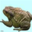

In [8]:
example = train_ds[10]
print('label :',id2label[example['label']])
example['img']

In [9]:

model = SwinForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

/var/folders/6h/42rvnp_n64x66b343njx8zvc0000gn/T/ipykernel_14486/3743677917.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [16]:
training_args = TrainingArguments(output_dir="./",
                                    remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=8,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
     

The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices


In [17]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 45000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 2812
  Number of trainable parameters = 27527044


  0%|          | 0/2812 [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::roll' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [13]:
dataset_test = load_dataset('cifar10',split='test')
dataset_test

Found cached dataset cifar10 (C:/Users/USER/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [14]:
model = SwinForImageClassification.from_pretrained(
    './checkpoint-2530/',
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True)

loading configuration file ./checkpoint-2530/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "plane",
    "1": "car",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "bird": 2,
    "car": 1,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "plane": 0,
    "ship": 8,
    "truck": 9
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_heads": [
    3,
    6,
    12,
    24
  ],
  "num_layers":

In [15]:
prepared_ds_test = dataset_test.with_transform(preprocess_val)

In [16]:
# Predictions
y_test_predict = trainer.predict(prepared_ds_test)

# Take a look at the predictions
y_test_predict

***** Running Prediction *****
  Num examples = 10000
  Batch size = 8
100%|██████████| 1250/1250 [01:12<00:00, 17.16it/s]


PredictionOutput(predictions=array([[-1.3795595 , -1.0865798 ,  0.31374252, ..., -2.0758958 ,
        -1.9242243 , -2.2798524 ],
       [ 2.288183  ,  1.3046619 , -1.8400929 , ..., -1.6009151 ,
         9.445768  , -0.386569  ],
       [ 1.8849508 ,  4.526985  , -1.8257655 , ..., -2.0384216 ,
         9.634069  , -0.0856154 ],
       ...,
       [-1.8887179 , -2.3407347 ,  0.3603206 , ..., -0.6589373 ,
        -1.3242996 , -2.0906086 ],
       [ 6.4276843 ,  6.0525246 , -0.05661407, ..., -2.9662435 ,
         0.2688176 , -0.7275618 ],
       [-1.9932609 , -1.4882847 ,  0.57215095, ..., 10.143873  ,
        -1.7015532 , -1.5447307 ]], dtype=float32), label_ids=array([3, 8, 8, ..., 5, 1, 7], dtype=int64), metrics={'test_loss': 0.08991346508264542, 'test_accuracy': 0.9705, 'test_runtime': 73.0214, 'test_samples_per_second': 136.946, 'test_steps_per_second': 17.118})